<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Main Calculation (Sensitivity Decomposition) ---
Processing Ts = 280.0 K...
Processing Ts = 281.0 K...
Processing Ts = 282.0 K...
Processing Ts = 283.0 K...
Processing Ts = 284.0 K...
Processing Ts = 285.0 K...
Processing Ts = 286.0 K...
Processing Ts = 287.0 K...
Processing Ts = 288.0 K...
Processing Ts = 289.0 K...
Processing Ts = 290.0 K...
Processing Ts = 291.0 K...
Processing Ts = 292.0 K...
Processing Ts = 293.0 K...
Processing Ts = 294.0 K...
Processing Ts = 295.0 K...
Processing Ts = 296.0 K...
Processing Ts = 297.0 K...
Processing Ts = 298.0 K...
Processing Ts = 299.0 K...
Processing Ts = 300.0 K...
Processing Ts = 301.0 K...
Processing Ts = 302.0 K...
Processing Ts = 303.0 K...
Processing Ts = 304.0 K...
Processing Ts = 305.0 K...
Processing Ts = 306.0 K...
Processing Ts = 307.0 K...
Processing Ts = 308.0 K...
Processing Ts = 309.0 K...
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.

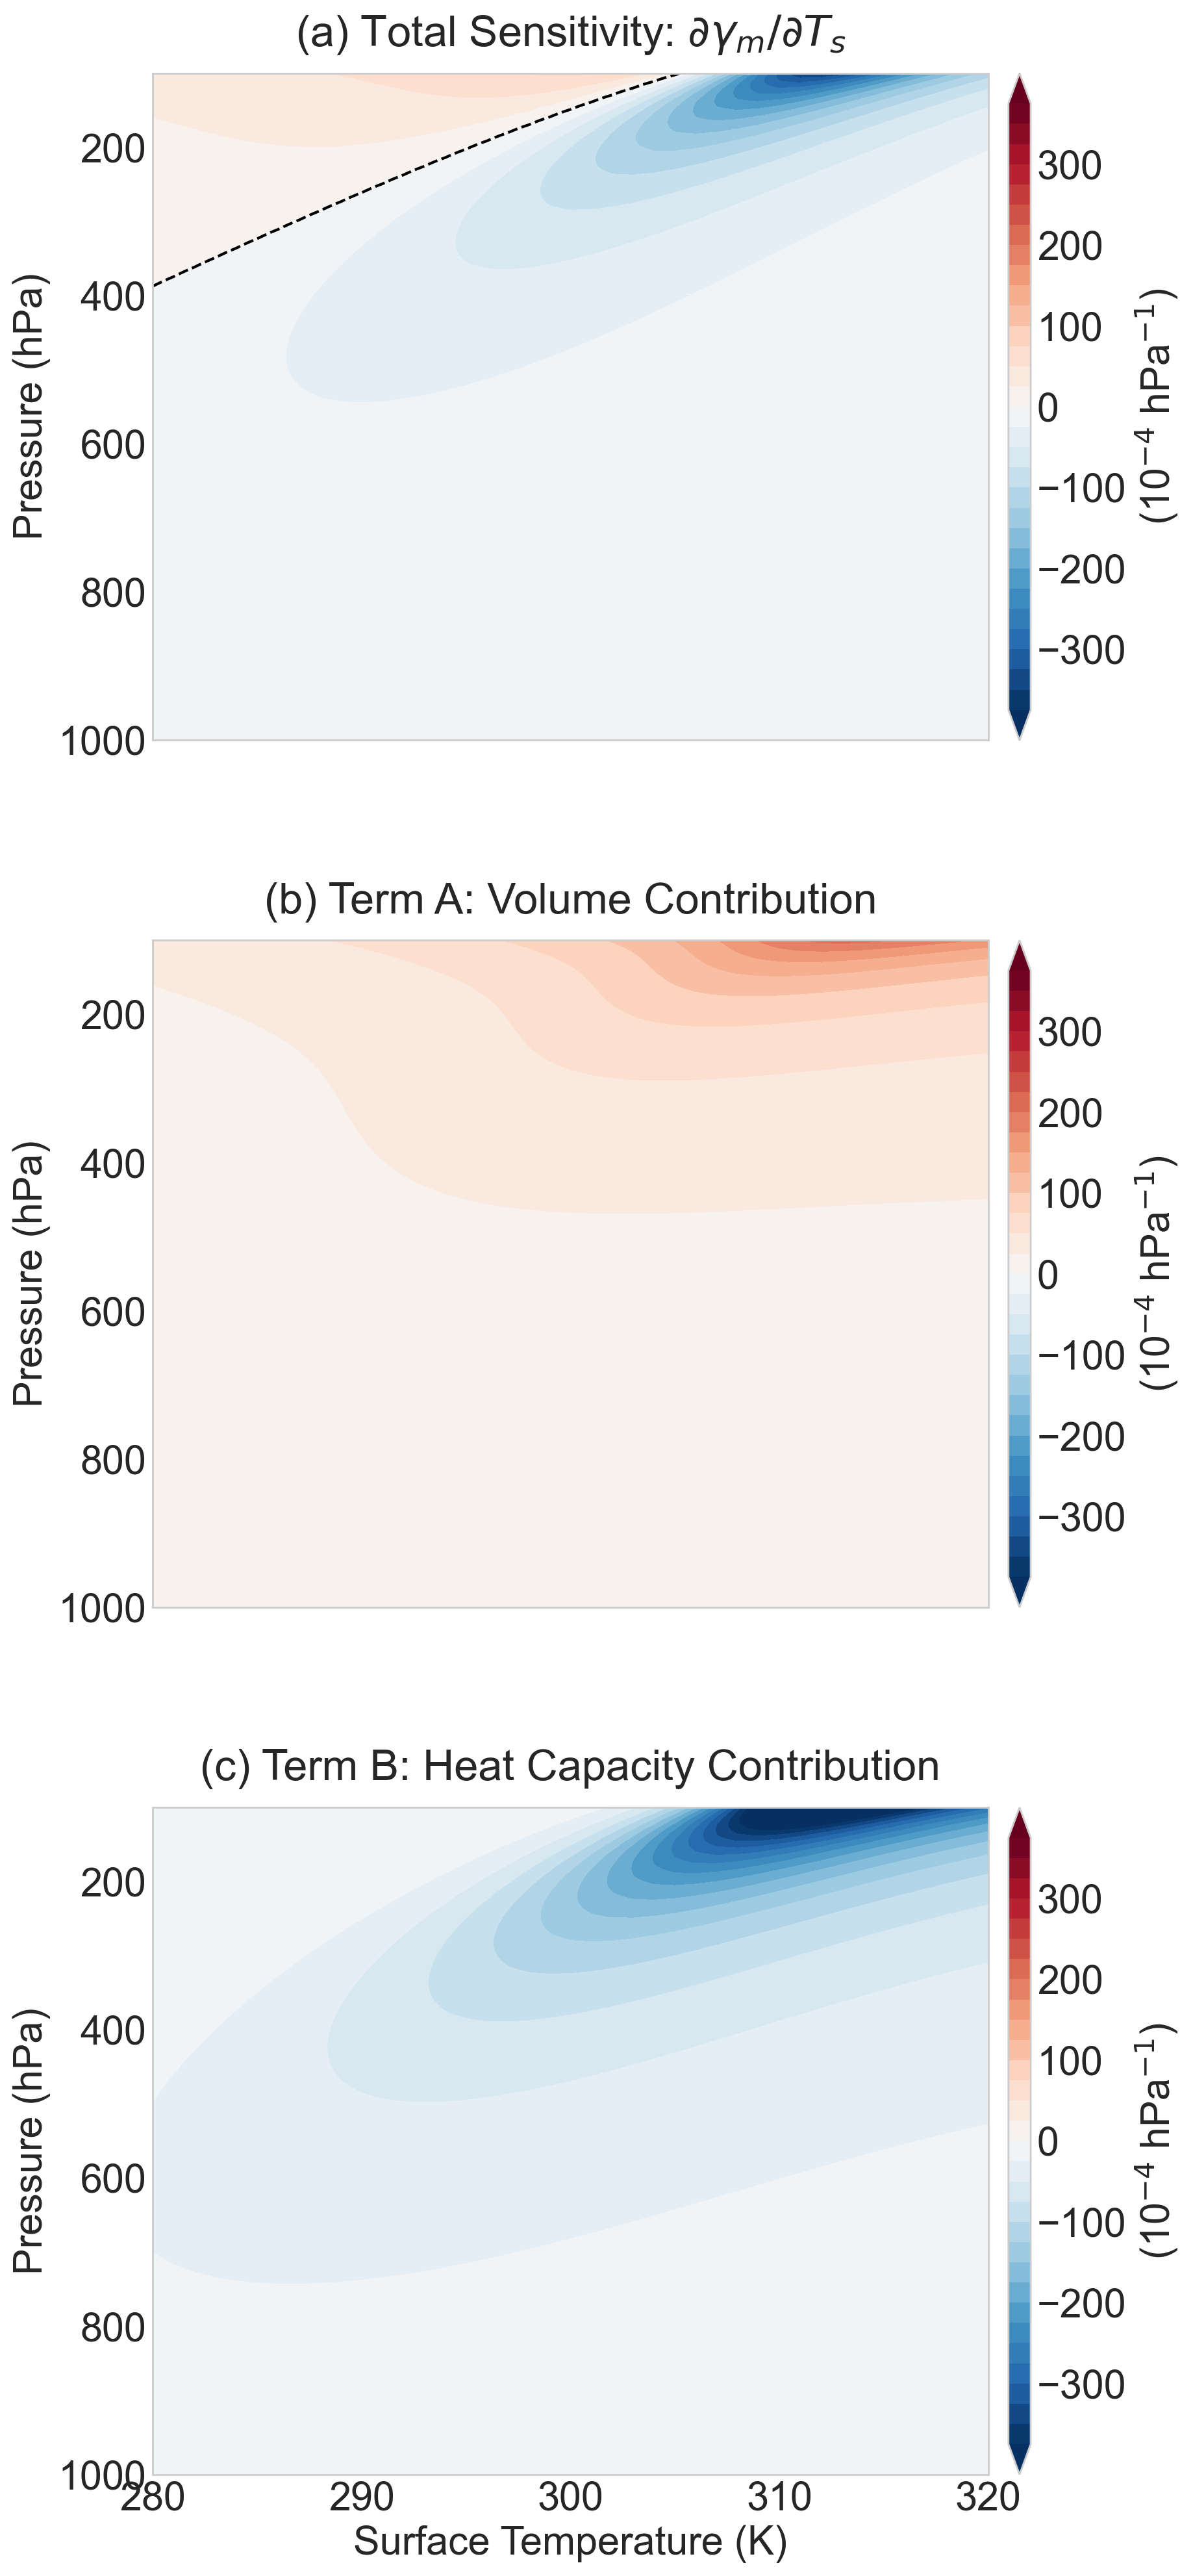

Figure 2 (contours, refined) saved as fig-2.png

Script finished.


In [6]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE 2 (Sensitivity Decomposition - Contours)
#
# This script performs the following actions:
# 1. Defines thermodynamic constants and functions, including new helpers for
#    the partial derivatives of saturation specific humidity (dqs/dT, dqs/dp).
# 2. Calculates moist adiabatic profiles for a range of surface temperatures (Ts)
#    and for a perturbed state (Ts + 4K).
# 3. For each profile, it computes the terms of the moist adiabat gamma_m:
#    - gamma_m = (alpha_d - alpha_L) / (c_pd + c_L)
# 4. It then numerically computes the sensitivity of gamma_m to Ts and
#    decomposes it into the two terms from the quotient rule.
# 5. It stores these results in 2D grids (Pressure vs. Ts).
# 6. Creates Figure 2, a three-panel filled contour plot showing the
#    sensitivity and the two decomposed terms as a function of Ts and pressure.
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---

def saturation_vapor_pressure(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    formula from Bolton (1980) (in Pa).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) (kg/kg)."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denominator, out=np.full_like(p, 1e-9), where=denominator>0)
    return np.maximum(qs, 1e-9)

def dqs_dT(p, T, dT=0.01):
    """Numerically calculates d(qs)/dT at constant p."""
    qs_plus = saturation_specific_humidity(p, T + dT)
    qs_minus = saturation_specific_humidity(p, T - dT)
    return (qs_plus - qs_minus) / (2 * dT)

def dqs_dp(p, T, dp=10.0):
    """Numerically calculates d(qs)/dp at constant T."""
    qs_plus = saturation_specific_humidity(p + dp, T)
    qs_minus = saturation_specific_humidity(p - dp, T)
    return (qs_plus - qs_minus) / (2 * dp)

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z):
    """Calculates Moist Static Energy (MSE) (J/kg)."""
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv * qs
    return mse

# --- Profile Calculation Function ---

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    """
    Calculates T(p) by conserving MSE at each pressure step.
    Returns the temperature profile on the p_grid.
    """
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)

    T_profile[0] = T_surf
    z_profile[0] = 0.0
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], z_profile[0])

    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]

        if np.isnan(T_curr) or p_curr <= 0: break

        Tv_curr = virtual_temperature(T_curr, p_curr)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next) - mse_conserved
        
        try:
            bracket = [150.0, T_curr + 5.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
            
    return T_profile

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Sensitivity Decomposition) ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 1.0)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)
delta_T_surf = 4.0

# Initialize 2D grids for storing results
n_p = len(p_grid)
n_t = len(T_surf_values)
d_gamma_m_dT_grid = np.full((n_p, n_t), np.nan)
term_A_grid = np.full((n_p, n_t), np.nan)
term_B_grid = np.full((n_p, n_t), np.nan)

for i, T_s in enumerate(T_surf_values):
    print(f"Processing Ts = {T_s:.1f} K...")
    T1 = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid)
    T2 = calculate_profile_with_rootfinder(T_s + delta_T_surf, p_surf_pa, p_grid)
    
    if not np.isnan(T1[-1]) and not np.isnan(T2[-1]):
        # Base state calculations
        gamma_m1 = np.gradient(T1, p_grid)
        c_L1 = Lv * dqs_dT(p_grid, T1)
        alpha_L1 = Lv * dqs_dp(p_grid, T1)
        alpha_d1 = Rd * T1 / p_grid
        
        # Perturbed state calculations
        gamma_m2 = np.gradient(T2, p_grid)
        c_L2 = Lv * dqs_dT(p_grid, T2)
        alpha_L2 = Lv * dqs_dp(p_grid, T2)
        alpha_d2 = Rd * T2 / p_grid
        
        # --- Calculate sensitivity terms and store in grid ---
        d_gamma_m_dT_grid[:, i] = (gamma_m2 - gamma_m1) / delta_T_surf
    
        # Define components for quotient rule
        N1 = alpha_d1 - alpha_L1
        N2 = alpha_d2 - alpha_L2
        D1 = cpd + c_L1
        D2 = cpd + c_L2
        
        dN_dT = (N2 - N1) / delta_T_surf
        dD_dT = (D2 - D1) / delta_T_surf
        
        N_avg = (N1 + N2) / 2.0
        D_avg = (D1 + D2) / 2.0
        
        term_A_grid[:, i] = dN_dT / D_avg
        term_B_grid[:, i] = (-N_avg * dD_dT) / (D_avg**2)
    else:
        print(f" -> Failed to generate complete profiles for Ts = {T_s:.1f} K.")

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Plotting Figure 2 (Contour Version) ---
print("--- Generating Figure 2 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize, 'axes.titlesize': base_fontsize + 2,
    'axes.labelsize': base_fontsize, 'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize, 'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(3, 1, figsize=(10, 24), sharex=True)
p_hpa_grid = p_grid / 100.0
T_grid_K, P_grid_hPa = np.meshgrid(T_surf_values, p_hpa_grid)

# Scale factor for better visualization
scale = 1e6

# Find the absolute maximum value across all three grids to unify the color scale
v_max = np.nanmax([
    np.abs(d_gamma_m_dT_grid),
    #np.abs(term_A_grid),
    #np.abs(term_B_grid)
]) * scale

# Define a step and create levels using arange for clean numbers
# Round v_max up to a clean number.
step = 25.0
limit = np.ceil(v_max / step) * step
levels = np.arange(-limit, limit + step, step)

# Ensure levels are valid, provide a fallback if all data is NaN
if len(levels) < 2:
    levels = np.arange(-200, 201, 50)

cmap = plt.get_cmap('RdBu_r')
plot_data = [
    {'grid': d_gamma_m_dT_grid * scale, 'title': r'(a) Total Sensitivity: $\partial \gamma_m / \partial T_{s}$'},
    {'grid': term_A_grid * scale, 'title': '(b) Term A: Volume Contribution'},
    {'grid': term_B_grid * scale, 'title': '(c) Term B: Heat Capacity Contribution'}
]

for i, ax in enumerate(axes):
    data = plot_data[i]
    contour = ax.contourf(T_grid_K, P_grid_hPa, data['grid'], levels=levels, cmap=cmap, extend='both')
    ax.contour(T_grid_K, P_grid_hPa, data['grid'], levels=[0], colors='k', linewidths=1.5, linestyles='--')
    
    ax.set_title(data['title'], pad=15)
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000, 100)
    
    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label('(10$^{-4}$ hPa$^{-1}$)')

axes[2].set_xlabel('Surface Temperature (K)')
fig.align_ylabels(axes)
plt.subplots_adjust(hspace=0.3)

fig2_filename = "fig-2.png"
plt.savefig(fig2_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure 2 (contours, refined) saved as {fig2_filename}")

print("\nScript finished.")
